# Electric Vehicle Accident Analysis

This notebook analyzes accident data for electric vehicles, focusing on predicting casualties (casulties include injuries as well as deaths) using various classification algorithms.

## 1. Importing Libraries

In [ ]:
# For handling data and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import random
import pickle
import os

# For machine learning models and pipelines
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    balanced_accuracy_score, roc_auc_score, average_precision_score
)

# For tuning hyperparameters and also handling imbalanced data
import optuna
from imblearn.over_sampling import SMOTE, ADASYN

In [173]:
# Settings for plotting styles and randomization
plt.style.use('ggplot')
sns.set_palette('Set2')
pio.renderers.default = "notebook"

random.seed(42)
np.random.seed(42)

## 2. Loading the Data

In [174]:
# Loading the data into a dataframe
df = pd.read_csv('final_data.csv')

In [175]:
# Display basic information about the dataset
print("\n Dataset shape: \n", df.shape)
print("\n Data types: \n")
print(df.dtypes)



 Dataset shape: 
 (1748161, 30)

 Data types: 

CRASH DATE & TIME                 object
BOROUGH                           object
ZIP CODE                           int64
LATITUDE                         float64
LONGITUDE                        float64
LOCATION                          object
NUMBER OF PERSONS INJURED          int64
NUMBER OF PERSONS KILLED           int64
NUMBER OF PEDESTRIANS INJURED      int64
NUMBER OF PEDESTRIANS KILLED       int64
NUMBER OF CYCLIST INJURED          int64
NUMBER OF CYCLIST KILLED           int64
NUMBER OF MOTORIST INJURED         int64
NUMBER OF MOTORIST KILLED          int64
CONTRIBUTING FACTOR VEHICLE 1     object
CONTRIBUTING FACTOR VEHICLE 2     object
CONTRIBUTING FACTOR VEHICLE 3     object
CONTRIBUTING FACTOR VEHICLE 4     object
CONTRIBUTING FACTOR VEHICLE 5     object
VEHICLE TYPE CODE 1               object
VEHICLE TYPE CODE 2               object
VEHICLE TYPE CODE 3               object
VEHICLE TYPE CODE 4               object
VEHICLE 

In [176]:
# Displaying the few rows of the dataset
df.head()

,CRASH DATE & TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,...,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,Addresses,Time of Day,NLat,NLong,Location,is_e_vehicle
0,2012-07-01 00:05:00,queens,11435,40.697753,-73.813916,"(40.6977532, -73.8139159)",1,0,0,0,...,sedan,NaN,NaN,NaN,NaN,night,NaN,NaN,NaN,False
1,2012-07-01 00:05:00,manhattan,10036,40.762127,-73.997387,"(40.7621266, -73.9973865)",0,0,0,0,...,bus,NaN,NaN,NaN,11 avenue west 44 street new york,night,NaN,NaN,NaN,False
2,2012-07-01 00:10:00,brooklyn,11223,40.588868,-73.972745,"(40.5888678, -73.9727446)",0,0,0,0,...,suv,NaN,NaN,NaN,west 3 street bouck court new york,night,NaN,NaN,NaN,False
3,2012-07-01 00:10:00,queens,11104,40.733610,-73.923840,"(40.73361, -73.9238405)",1,0,0,0,...,suv,suv,sedan,NaN,NaN,night,NaN,NaN,NaN,False
4,2012-07-01 00:20:00,brooklyn,11215,40.677406,-73.983048,"(40.6774056, -73.9830482)",0,0,0,0,...,bicycle,NaN,NaN,NaN,4 avenue union street new york,night,NaN,NaN,NaN,False


In [177]:
# Only selecting electric vehicles and printing the number of electric vehicle accidents
df = df[df['is_e_vehicle'] == True]
print(f"Number of electric vehicle accidents: {len(df)}")


Number of electric vehicle accidents: 18531


In [178]:
# Adding a new column for causality
df['CAUSALITY'] = ((df['NUMBER OF PERSONS INJURED'] > 0) | (df['NUMBER OF PERSONS KILLED'] > 0)).astype(int)


In [179]:
# Checking the class distribution to see it there is an imbalance in the classes
causality_counts = df['CAUSALITY'].value_counts()
print("\nCausality class distribution:")
print(causality_counts)
print(f"Class 0 (no injury/death): {causality_counts[0]/len(df)*100:.2f}%")
print(f"Class 1 (injury/death): {causality_counts[1]/len(df)*100:.2f}%")


Causality class distribution:
CAUSALITY
1    14634
0     3897
Name: count, dtype: int64
Class 0 (no injury/death): 21.03%
Class 1 (injury/death): 78.97%


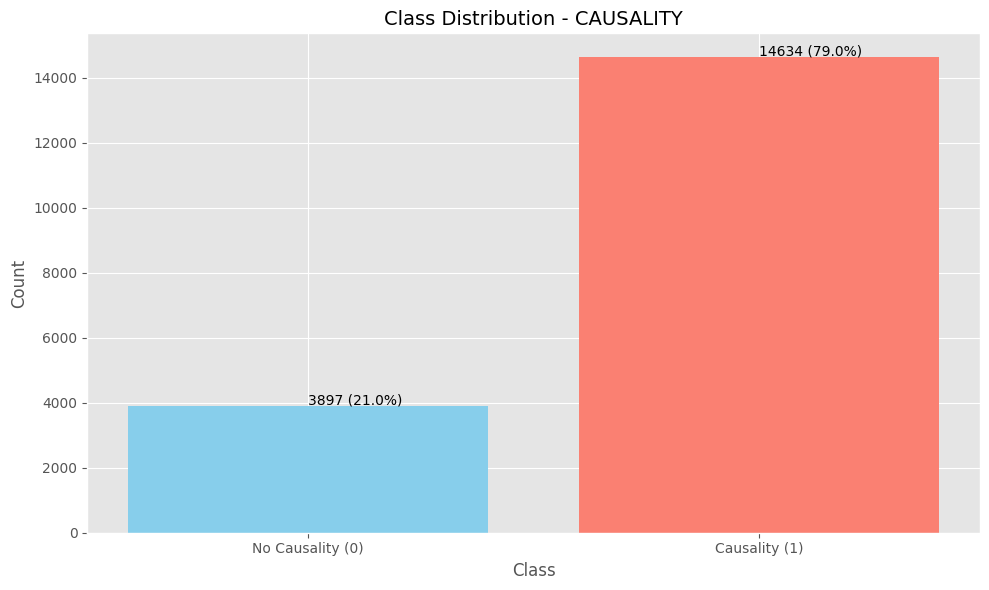

In [180]:
# Plotting a bar graph to see if there is an imbalance in the clsees
plt.figure(figsize=(10, 6))
causality_counts = df['CAUSALITY'].value_counts().sort_index()
plt.bar(['No Causality (0)', 'Causality (1)'], causality_counts.values, color=['skyblue', 'salmon'])
plt.title('Class Distribution - CAUSALITY', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Count')

for i, v in enumerate(causality_counts.values):
    plt.text(i, v + 50, f"{v} ({v/len(df)*100:.1f}%)")

plt.tight_layout()
plt.show()

## 3. Feature engineering and selections

In [181]:
# Converting date and time columns to datetime format column
df['CRASH DATE & TIME'] = pd.to_datetime(df['CRASH DATE & TIME'], errors='coerce')

In [182]:
# Extracting date and time like features from the datetime columns
df['Year'] = df['CRASH DATE & TIME'].dt.year
df['Month'] = df['CRASH DATE & TIME'].dt.month
df['Day'] = df['CRASH DATE & TIME'].dt.day
df['Hour'] = df['CRASH DATE & TIME'].dt.hour
df['DayOfWeek'] = df['CRASH DATE & TIME'].dt.dayofweek  #0: Monday, 6: Sunday


In [183]:
# displaying the newly created features
df[['CRASH DATE & TIME', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek']].head()

,CRASH DATE & TIME,Year,Month,Day,Hour,DayOfWeek
61,2012-07-01 03:58:00,2012,7,1,3,6
1433,2012-07-03 18:40:00,2012,7,3,18,1
1760,2012-07-04 16:00:00,2012,7,4,16,2
1858,2012-07-04 20:30:00,2012,7,4,20,2
2203,2012-07-05 13:49:00,2012,7,5,13,3


In [184]:
# Selecting the features that are most relevant to our problem statement
features = [ 'Month', 'Day', 'Hour', 'DayOfWeek', 'VEHICLE TYPE CODE 2', 'ZIP CODE', 'CONTRIBUTING FACTOR VEHICLE 1']


In [185]:
# Definining a target variable.
ClassificationTargetVar = 'CAUSALITY'

In [186]:
# Dropping the rows that have missing values in the selected feature columns
Cleaneddf = df.dropna(subset=features + [ClassificationTargetVar])

# Printing the shape to see the number of rows and columns in the dataset present at this moment
print(f"Original dataset shape: {df.shape}")
print(f"Clean dataset shape: {Cleaneddf.shape}")

Original dataset shape: (18531, 36)
Clean dataset shape: (15226, 36)


In [187]:
# Creatinng additional features based on time of the crash
# we define Rush hour as: 7-9 AM and 4-7 PM
Cleaneddf['IsRushHour'] = (
    ((Cleaneddf['Hour'] >= 7) & (Cleaneddf['Hour'] <= 9)) | 
    ((Cleaneddf['Hour'] >= 16) & (Cleaneddf['Hour'] <= 19))
).astype(int)

# we define Night time as: 10 PM to 5 AM
Cleaneddf['IsNightTime'] = ((Cleaneddf['Hour'] >= 22) | (Cleaneddf['Hour'] <= 5)).astype(int)

# we define Weekend as: Saturday (5) and Sunday (6)
Cleaneddf['IsWeekend'] = (Cleaneddf['DayOfWeek'] >= 5).astype(int)


C:\Users\potda\AppData\Local\Temp\ipykernel_8144\925992308.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\potda\AppData\Local\Temp\ipykernel_8144\925992308.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\potda\AppData\Local\Temp\ipykernel_8144\925992308.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

In [188]:
# Adding the new features to our list of features
features.extend(['IsRushHour', 'IsWeekend', 'IsNightTime'])

# Displaying the stats of the newly created feature columns
Cleaneddf[['IsRushHour', 'IsWeekend', 'IsNightTime']].describe()

,IsRushHour,IsWeekend,IsNightTime
count,15226.000000,15226.000000,15226.000000
mean,0.395836,0.247603,0.165112
std,0.489046,0.431634,0.371294
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000


## 4. Data Preprocessing and Splitting the data

In [189]:
# Defining the categorical and numeric columns
categorical_cols = ['VEHICLE TYPE CODE 2', 'CONTRIBUTING FACTOR VEHICLE 1']
numeric_cols = [col for col in features if col not in categorical_cols]


In [190]:
# Printing the same
print("Numerical columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

Numerical columns: ['Month', 'Day', 'Hour', 'DayOfWeek', 'ZIP CODE', 'IsRushHour', 'IsWeekend', 'IsNightTime']
Categorical columns: ['VEHICLE TYPE CODE 2', 'CONTRIBUTING FACTOR VEHICLE 1']


In [191]:
# Preparting features and target for our model
X = Cleaneddf[features]
y_causality = Cleaneddf[ClassificationTargetVar]


In [192]:
# Splitting the data into training and testing
X_train, X_test, y_train_causality, y_test_causality = train_test_split(
    X, y_causality, test_size=0.2, random_state=42, stratify=y_causality
)


In [193]:
print(f"Training set shape: {X_train.shape}, Class distribution: {pd.Series(y_train_causality).value_counts()}")
print(f"Testing set shape: {X_test.shape}, Class distribution: {pd.Series(y_test_causality).value_counts()}")

Training set shape: (12180, 10), Class distribution: CAUSALITY
1    9272
0    2908
Name: count, dtype: int64
Testing set shape: (3046, 10), Class distribution: CAUSALITY
1    2319
0     727
Name: count, dtype: int64


## 5. Handling class imbalance with ADASYN (Oversampling the data)

In [194]:
# defining a function to apply ADASYN
def apply_ADASYN(X_train, y_train):
    X_train_processed = X_train.copy()
    for col in categorical_cols:
        if col in X_train_processed.columns:
            X_train_processed[col] = pd.Categorical(X_train_processed[col]).codes

    data_balanced = ADASYN(random_state=42)
    X_resampled, y_resampled = data_balanced.fit_resample(X_train_processed, y_train)
    
    return X_resampled, y_resampled


In [195]:
# Applying ADASYN to balance the dataset
print("Applying ADASYN to balance class distribution")
X_train_balanced, y_train_balanced = apply_ADASYN(X_train, y_train_causality)


Applying ADASYN to balance class distribution


In [196]:
# Checking class distribution before ADASYN
print("\nOriginal class distribution:")
print(pd.Series(y_train_causality).value_counts())



Original class distribution:
CAUSALITY
1    9272
0    2908
Name: count, dtype: int64


In [197]:
# After ADASYN
print("\nBalanced class distribution:")
print(pd.Series(y_train_balanced).value_counts())


Balanced class distribution:
CAUSALITY
1    9272
0    9188
Name: count, dtype: int64


In [198]:
# Doint the same for test data
X_test_processed = X_test.copy()
for col in categorical_cols:
    if col in X_test_processed.columns:
        X_test_processed[col] = pd.Categorical(X_test_processed[col]).codes

## 6. Creating Pipeline and Initializing the models

In [199]:
# Defining a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])


In [200]:
# Starting all the models for classification
classifier_models = {
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier())
    ]),
    'RF': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(random_state=42))
    ]),
    'GB': Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingClassifier(random_state=42))
    ]),
    'DT': Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(random_state=42))
    ]),
    'ET': Pipeline([
        ('preprocessor', preprocessor),
        ('model', ExtraTreesClassifier(random_state=42))
    ]),
    'LR': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(random_state=42))
    ]),
    'NB': Pipeline([
        ('preprocessor', preprocessor),
        ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
        ('model', GaussianNB())
    ]),
    'ADA': Pipeline([
        ('preprocessor', preprocessor),
        ('model', AdaBoostClassifier(random_state=42))
    ])
}

## 7. Optimizing the Hyperparameter with Optuna for better results

In [201]:
# Defining a function to optimize the hyperparameters for each model
# KNN
def objective_knn(trial):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights))
    ])
    
    return -np.mean(cross_val_score(model, X_train, y_train_causality, cv=5, scoring='f1_weighted'))


In [202]:
# Random Forest
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        ))
    ])
    
    return -np.mean(cross_val_score(model, X_train, y_train_causality, cv=5, scoring='f1_weighted'))

In [203]:
# Gradient Boosting
def objective_gb(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', GradientBoostingClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=42
        ))
    ])
    
    return -np.mean(cross_val_score(model, X_train, y_train_causality, cv=5, scoring='f1_weighted'))

In [204]:
# Decision Tree
def objective_dt(trial):
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier(
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        ))
    ])
    
    return -np.mean(cross_val_score(model, X_train, y_train_causality, cv=5, scoring='f1_weighted'))

In [205]:
# Extra Trees
def objective_et(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', ExtraTreesClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        ))
    ])
    
    return -np.mean(cross_val_score(model, X_train, y_train_causality, cv=5, scoring='f1_weighted'))

In [206]:
# Logistic Regression
def objective_logreg(trial):
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    max_iter = trial.suggest_int('max_iter', 100, 500)
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(
            C=C, solver=solver, max_iter=max_iter, random_state=42
        ))
    ])
    
    return -np.mean(cross_val_score(model, X_train, y_train_causality, cv=5, scoring='f1_weighted'))

In [207]:
# Naive Bayes
def objective_nb(trial):
    var_smoothing = trial.suggest_float('var_smoothing', 1e-10, 1e-8, log=True)
    
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('to_dense', FunctionTransformer(lambda x: x.toarray() if hasattr(x, 'toarray') else x)),
        ('model', GaussianNB(var_smoothing=var_smoothing))
    ])
    
    return -np.mean(cross_val_score(model, X_train, y_train_causality, cv=5, scoring='f1_weighted'))

In [208]:
# AdaBoost
def objective_adaboost(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
    algorithm = 'SAMME'
    
    base_estimator = DecisionTreeClassifier(max_depth=1)
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('model', AdaBoostClassifier(
            estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            algorithm=algorithm,
            random_state=42
        ))
    ])
    
    return -np.mean(cross_val_score(model, X_train, y_train_causality, cv=5, scoring='f1_weighted'))

In [209]:
# Running hyperparameter optimization on all models
print("\n Optimizing KNN hyperparameters \n")
study_knn = optuna.create_study(direction='minimize')
study_knn.optimize(objective_knn, n_trials=10)

print("\n Optimizing Random Forest hyperparameters \n")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=10)

print("\n Optimizing Gradient Boosting hyperparameters \n")
study_gb = optuna.create_study(direction='minimize')
study_gb.optimize(objective_gb, n_trials=10)

print("\n Optimizing Decision Tree hyperparameters \n")
study_dt = optuna.create_study(direction='minimize')
study_dt.optimize(objective_dt, n_trials=10)

print("\n Optimizing Extra Trees hyperparameters \n")
study_et = optuna.create_study(direction='minimize')
study_et.optimize(objective_et, n_trials=10)

print("\n Optimizing Logistic Regression hyperparameters \n")
study_logreg = optuna.create_study(direction='minimize')
study_logreg.optimize(objective_logreg, n_trials=10)

print("\n Optimizing Naive Bayes hyperparameters \n")
study_nb = optuna.create_study(direction='minimize')
study_nb.optimize(objective_nb, n_trials=10)

print("\n Optimizing AdaBoost hyperparameters \n")
study_ada = optuna.create_study(direction='minimize')
study_ada.optimize(objective_adaboost, n_trials=10)

print("\n Optimized all the models \n")



 Optimizing KNN hyperparameters 



[I 2025-05-01 22:02:35,844] A new study created in memory with name: no-name-65881139-9ba7-4ac3-b100-fc7459230df4
[I 2025-05-01 22:02:39,099] Trial 0 finished with value: -0.661975017074823 and parameters: {'n_neighbors': 10, 'weights': 'distance'}. Best is trial 0 with value: -0.661975017074823.
[I 2025-05-01 22:02:42,278] Trial 1 finished with value: -0.6303066054226143 and parameters: {'n_neighbors': 1, 'weights': 'distance'}. Best is trial 0 with value: -0.661975017074823.
[I 2025-05-01 22:02:45,441] Trial 2 finished with value: -0.6557510256144095 and parameters: {'n_neighbors': 3, 'weights': 'distance'}. Best is trial 0 with value: -0.661975017074823.
[I 2025-05-01 22:02:48,642] Trial 3 finished with value: -0.6585889792416271 and parameters: {'n_neighbors': 18, 'weights': 'uniform'}. Best is trial 0 with value: -0.661975017074823.
[I 2025-05-01 22:02:51,893] Trial 4 finished with value: -0.6622132737263768 and parameters: {'n_neighbors': 6, 'weights': 'distance'}. Best is trial 


 Optimizing Random Forest hyperparameters 



[I 2025-05-01 22:03:08,273] Trial 0 finished with value: -0.6580543658025799 and parameters: {'n_estimators': 54, 'max_depth': 3, 'min_samples_split': 19}. Best is trial 0 with value: -0.6580543658025799.
[I 2025-05-01 22:03:12,029] Trial 1 finished with value: -0.6580140610385633 and parameters: {'n_estimators': 190, 'max_depth': 6, 'min_samples_split': 7}. Best is trial 0 with value: -0.6580543658025799.
[I 2025-05-01 22:03:14,962] Trial 2 finished with value: -0.6580543658025799 and parameters: {'n_estimators': 164, 'max_depth': 5, 'min_samples_split': 6}. Best is trial 0 with value: -0.6580543658025799.
[I 2025-05-01 22:03:21,710] Trial 3 finished with value: -0.6580543658025799 and parameters: {'n_estimators': 300, 'max_depth': 7, 'min_samples_split': 2}. Best is trial 0 with value: -0.6580543658025799.
[I 2025-05-01 22:03:35,610] Trial 4 finished with value: -0.6582086582988835 and parameters: {'n_estimators': 295, 'max_depth': 13, 'min_samples_split': 19}. Best is trial 4 with v


 Optimizing Gradient Boosting hyperparameters 



[I 2025-05-01 22:04:20,889] Trial 0 finished with value: -0.6628359337300431 and parameters: {'n_estimators': 135, 'max_depth': 5, 'learning_rate': 0.11478571259016597}. Best is trial 0 with value: -0.6628359337300431.
[I 2025-05-01 22:04:34,082] Trial 1 finished with value: -0.6718171301287572 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.23447722654731154}. Best is trial 1 with value: -0.6718171301287572.
[I 2025-05-01 22:04:49,552] Trial 2 finished with value: -0.6696321824052563 and parameters: {'n_estimators': 116, 'max_depth': 7, 'learning_rate': 0.18864162791106542}. Best is trial 1 with value: -0.6718171301287572.
[I 2025-05-01 22:05:05,665] Trial 3 finished with value: -0.6685795382591774 and parameters: {'n_estimators': 153, 'max_depth': 6, 'learning_rate': 0.25760239289095194}. Best is trial 1 with value: -0.6718171301287572.
[I 2025-05-01 22:06:19,620] Trial 4 finished with value: -0.6667979463654135 and parameters: {'n_estimators': 259, 'max_dept


 Optimizing Decision Tree hyperparameters 



[I 2025-05-01 22:08:24,414] Trial 0 finished with value: -0.6651573372421618 and parameters: {'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 19}. Best is trial 0 with value: -0.6651573372421618.
[I 2025-05-01 22:08:24,637] Trial 1 finished with value: -0.660229096976056 and parameters: {'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 17}. Best is trial 0 with value: -0.6651573372421618.
[I 2025-05-01 22:08:24,861] Trial 2 finished with value: -0.6622254854845192 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 4}. Best is trial 0 with value: -0.6651573372421618.
[I 2025-05-01 22:08:25,121] Trial 3 finished with value: -0.6626987184150621 and parameters: {'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 17}. Best is trial 0 with value: -0.6651573372421618.
[I 2025-05-01 22:08:25,642] Trial 4 finished with value: -0.6611601628201433 and parameters: {'max_depth': 12, 'min_samples_split': 12, 'min_samples_leaf': 12}. Best i


 Optimizing Extra Trees hyperparameters 



[I 2025-05-01 22:08:30,574] Trial 0 finished with value: -0.6590982977328725 and parameters: {'n_estimators': 173, 'max_depth': 10, 'min_samples_split': 6}. Best is trial 0 with value: -0.6590982977328725.
[I 2025-05-01 22:08:38,071] Trial 1 finished with value: -0.6592915405761708 and parameters: {'n_estimators': 261, 'max_depth': 13, 'min_samples_split': 10}. Best is trial 1 with value: -0.6592915405761708.
[I 2025-05-01 22:08:46,654] Trial 2 finished with value: -0.659791362854552 and parameters: {'n_estimators': 157, 'max_depth': 18, 'min_samples_split': 5}. Best is trial 2 with value: -0.659791362854552.
[I 2025-05-01 22:08:52,594] Trial 3 finished with value: -0.6596363042177182 and parameters: {'n_estimators': 143, 'max_depth': 17, 'min_samples_split': 20}. Best is trial 2 with value: -0.659791362854552.
[I 2025-05-01 22:08:57,146] Trial 4 finished with value: -0.6591391664432915 and parameters: {'n_estimators': 217, 'max_depth': 10, 'min_samples_split': 10}. Best is trial 2 wit


 Optimizing Logistic Regression hyperparameters 



c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2025-05-01 22:09:25,878] Trial 0


 Optimizing Naive Bayes hyperparameters 



[I 2025-05-01 22:09:31,324] Trial 1 finished with value: -0.38211119843575847 and parameters: {'var_smoothing': 2.871162791080737e-09}. Best is trial 1 with value: -0.38211119843575847.
[I 2025-05-01 22:09:31,516] Trial 2 finished with value: -0.2568982834698459 and parameters: {'var_smoothing': 3.2009042624400877e-10}. Best is trial 1 with value: -0.38211119843575847.
[I 2025-05-01 22:09:31,700] Trial 3 finished with value: -0.23434814083985728 and parameters: {'var_smoothing': 1.6524617671315411e-10}. Best is trial 1 with value: -0.38211119843575847.
[I 2025-05-01 22:09:31,884] Trial 4 finished with value: -0.2818857682511304 and parameters: {'var_smoothing': 7.046721192592466e-10}. Best is trial 1 with value: -0.38211119843575847.
[I 2025-05-01 22:09:32,069] Trial 5 finished with value: -0.551850299008757 and parameters: {'var_smoothing': 9.8480248630058e-09}. Best is trial 5 with value: -0.551850299008757.
[I 2025-05-01 22:09:32,255] Trial 6 finished with value: -0.3126897859442205


 Optimizing AdaBoost hyperparameters 



c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.

c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.

c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.

c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.

[I 2025-05-01 22:09:35,567] Trial 0 finished with value: -0.65805436


 Optimized all the models 



In [210]:
# Printing best hyperparameters for all the models
print("\n Best KNN parameters: \n", study_knn.best_params)
print("\n Best KNN metric: \n", -study_knn.best_value)

print("\n Best Random Forest parameters: \n", study_rf.best_params)
print("\n Best Random Forest metric: \n", -study_rf.best_value)

print("\n Best Gradient Boosting parameters: \n", study_gb.best_params)
print("\n Best Gradient Boosting metric: \n", -study_gb.best_value)

print("\n Best Decision Tree parameters: \n", study_dt.best_params)
print("\n Best Decision Tree metric: \n", -study_dt.best_value)

print("\n Best Extra Trees parameters: \n", study_et.best_params)
print("\n Best Extra Trees metric: \n", -study_et.best_value)

print("\n Best Logistic Regression parameters: \n", study_logreg.best_params)
print("\n Best Logistic Regression metric: \n", -study_logreg.best_value)

print("\n Best Naive Bayes parameters: \n", study_nb.best_params)
print("\n Best Naive Bayes metric: \n", -study_nb.best_value)

print("\n Best AdaBoost parameters: \n", study_ada.best_params)
print("\n Best AdaBoost metric: \n", -study_ada.best_value)



 Best KNN parameters: 
 {'n_neighbors': 6, 'weights': 'distance'}

 Best KNN metric: 
 0.6622132737263768

 Best Random Forest parameters: 
 {'n_estimators': 295, 'max_depth': 13, 'min_samples_split': 19}

 Best Random Forest metric: 
 0.6582086582988835

 Best Gradient Boosting parameters: 
 {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.23447722654731154}

 Best Gradient Boosting metric: 
 0.6718171301287572

 Best Decision Tree parameters: 
 {'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 19}

 Best Decision Tree metric: 
 0.6651573372421618

 Best Extra Trees parameters: 
 {'n_estimators': 157, 'max_depth': 18, 'min_samples_split': 5}

 Best Extra Trees metric: 
 0.659791362854552

 Best Logistic Regression parameters: 
 {'C': 0.12254117289879263, 'solver': 'saga', 'max_iter': 352}

 Best Logistic Regression metric: 
 0.6580543658025799

 Best Naive Bayes parameters: 
 {'var_smoothing': 9.8480248630058e-09}

 Best Naive Bayes metric: 
 0.551850299008757

 

## 8. Training the models and evaluating models

In [211]:
# Updating models with optimized hyperparameters based on the ones we got from previous step
optimized_models = {
    'KNN': KNeighborsClassifier(**study_knn.best_params),
    'RF': RandomForestClassifier(**study_rf.best_params, random_state=42),
    'GB': GradientBoostingClassifier(**study_gb.best_params, random_state=42),
    'DT': DecisionTreeClassifier(**study_dt.best_params, random_state=42),
    'ET': ExtraTreesClassifier(**study_et.best_params, random_state=42),
    'LR': LogisticRegression(**study_logreg.best_params, random_state=42),
    'NB': GaussianNB(**study_nb.best_params),
    'ADA': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1),
        n_estimators=study_ada.best_params.get('n_estimators', 100),
        learning_rate=study_ada.best_params.get('learning_rate', 0.1),
        algorithm='SAMME',
        random_state=42
    )
}

In [212]:
# Defining the function to train and evaluate the results of every model
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    results = []
    
    for model_name, model in models.items():
        print(f"Training {model_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # calculating the metrics for all models
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        cm = confusion_matrix(y_test, y_pred)
        balanced_acc = balanced_accuracy_score(y_test, y_pred)
        
        # Calculating AUC for models that have probability predictons if the model supports probability prediction
        auc = None
        if hasattr(model, "predict_proba") and len(np.unique(y_test)) == 2:
            try:
                y_prob = model.predict_proba(X_test)[:, 1]
                auc = roc_auc_score(y_test, y_prob)
            except:
                pass
        
        # Making the results report for every model
        results.append({
            'model_name': model_name,
            'accuracy': accuracy,
            'balanced_accuracy': balanced_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'confusion_matrix': cm,
            'classification_report': classification_report(y_test, y_pred)
        })
    
    return results

In [213]:
# Training models with the data that is balanced with ADASYN that we did earlier
print("\n Training models with balanced data: \n")
balanced_results = train_and_evaluate(
    optimized_models,
    X_train_balanced, y_train_balanced,
    X_test_processed, y_test_causality
)


 Training models with balanced data: 

Training KNN
Training RF
Training GB
Training DT
Training ET
Training LR


c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning:

The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.



Training NB
Training ADA


In [214]:
# Prining the results for all the models
for result in balanced_results:
    print(f"\n {'-'*50} \n")
    print(f"Model: {result['model_name']}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Balanced Accuracy: {result['balanced_accuracy']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1']:.4f}")
    if result['auc'] is not None:
        print(f"AUC: {result['auc']:.4f}")
    
    print("\n Confusion Matrix: \n")
    print(result['confusion_matrix'])
    
    print("\n Classification Report: \n")
    print(result['classification_report'])


 -------------------------------------------------- 

Model: KNN
Accuracy: 0.5407
Balanced Accuracy: 0.5090
Precision: 0.6428
Recall: 0.5407
F1 Score: 0.5736
AUC: 0.5113

 Confusion Matrix: 

[[ 326  401]
 [ 998 1321]]

 Classification Report: 

              precision    recall  f1-score   support

           0       0.25      0.45      0.32       727
           1       0.77      0.57      0.65      2319

    accuracy                           0.54      3046
   macro avg       0.51      0.51      0.49      3046
weighted avg       0.64      0.54      0.57      3046


 -------------------------------------------------- 

Model: RF
Accuracy: 0.5000
Balanced Accuracy: 0.4837
Precision: 0.6250
Recall: 0.5000
F1 Score: 0.5369
AUC: 0.4884

 Confusion Matrix: 

[[ 329  398]
 [1125 1194]]

 Classification Report: 

              precision    recall  f1-score   support

           0       0.23      0.45      0.30       727
           1       0.75      0.51      0.61      2319

    accuracy    

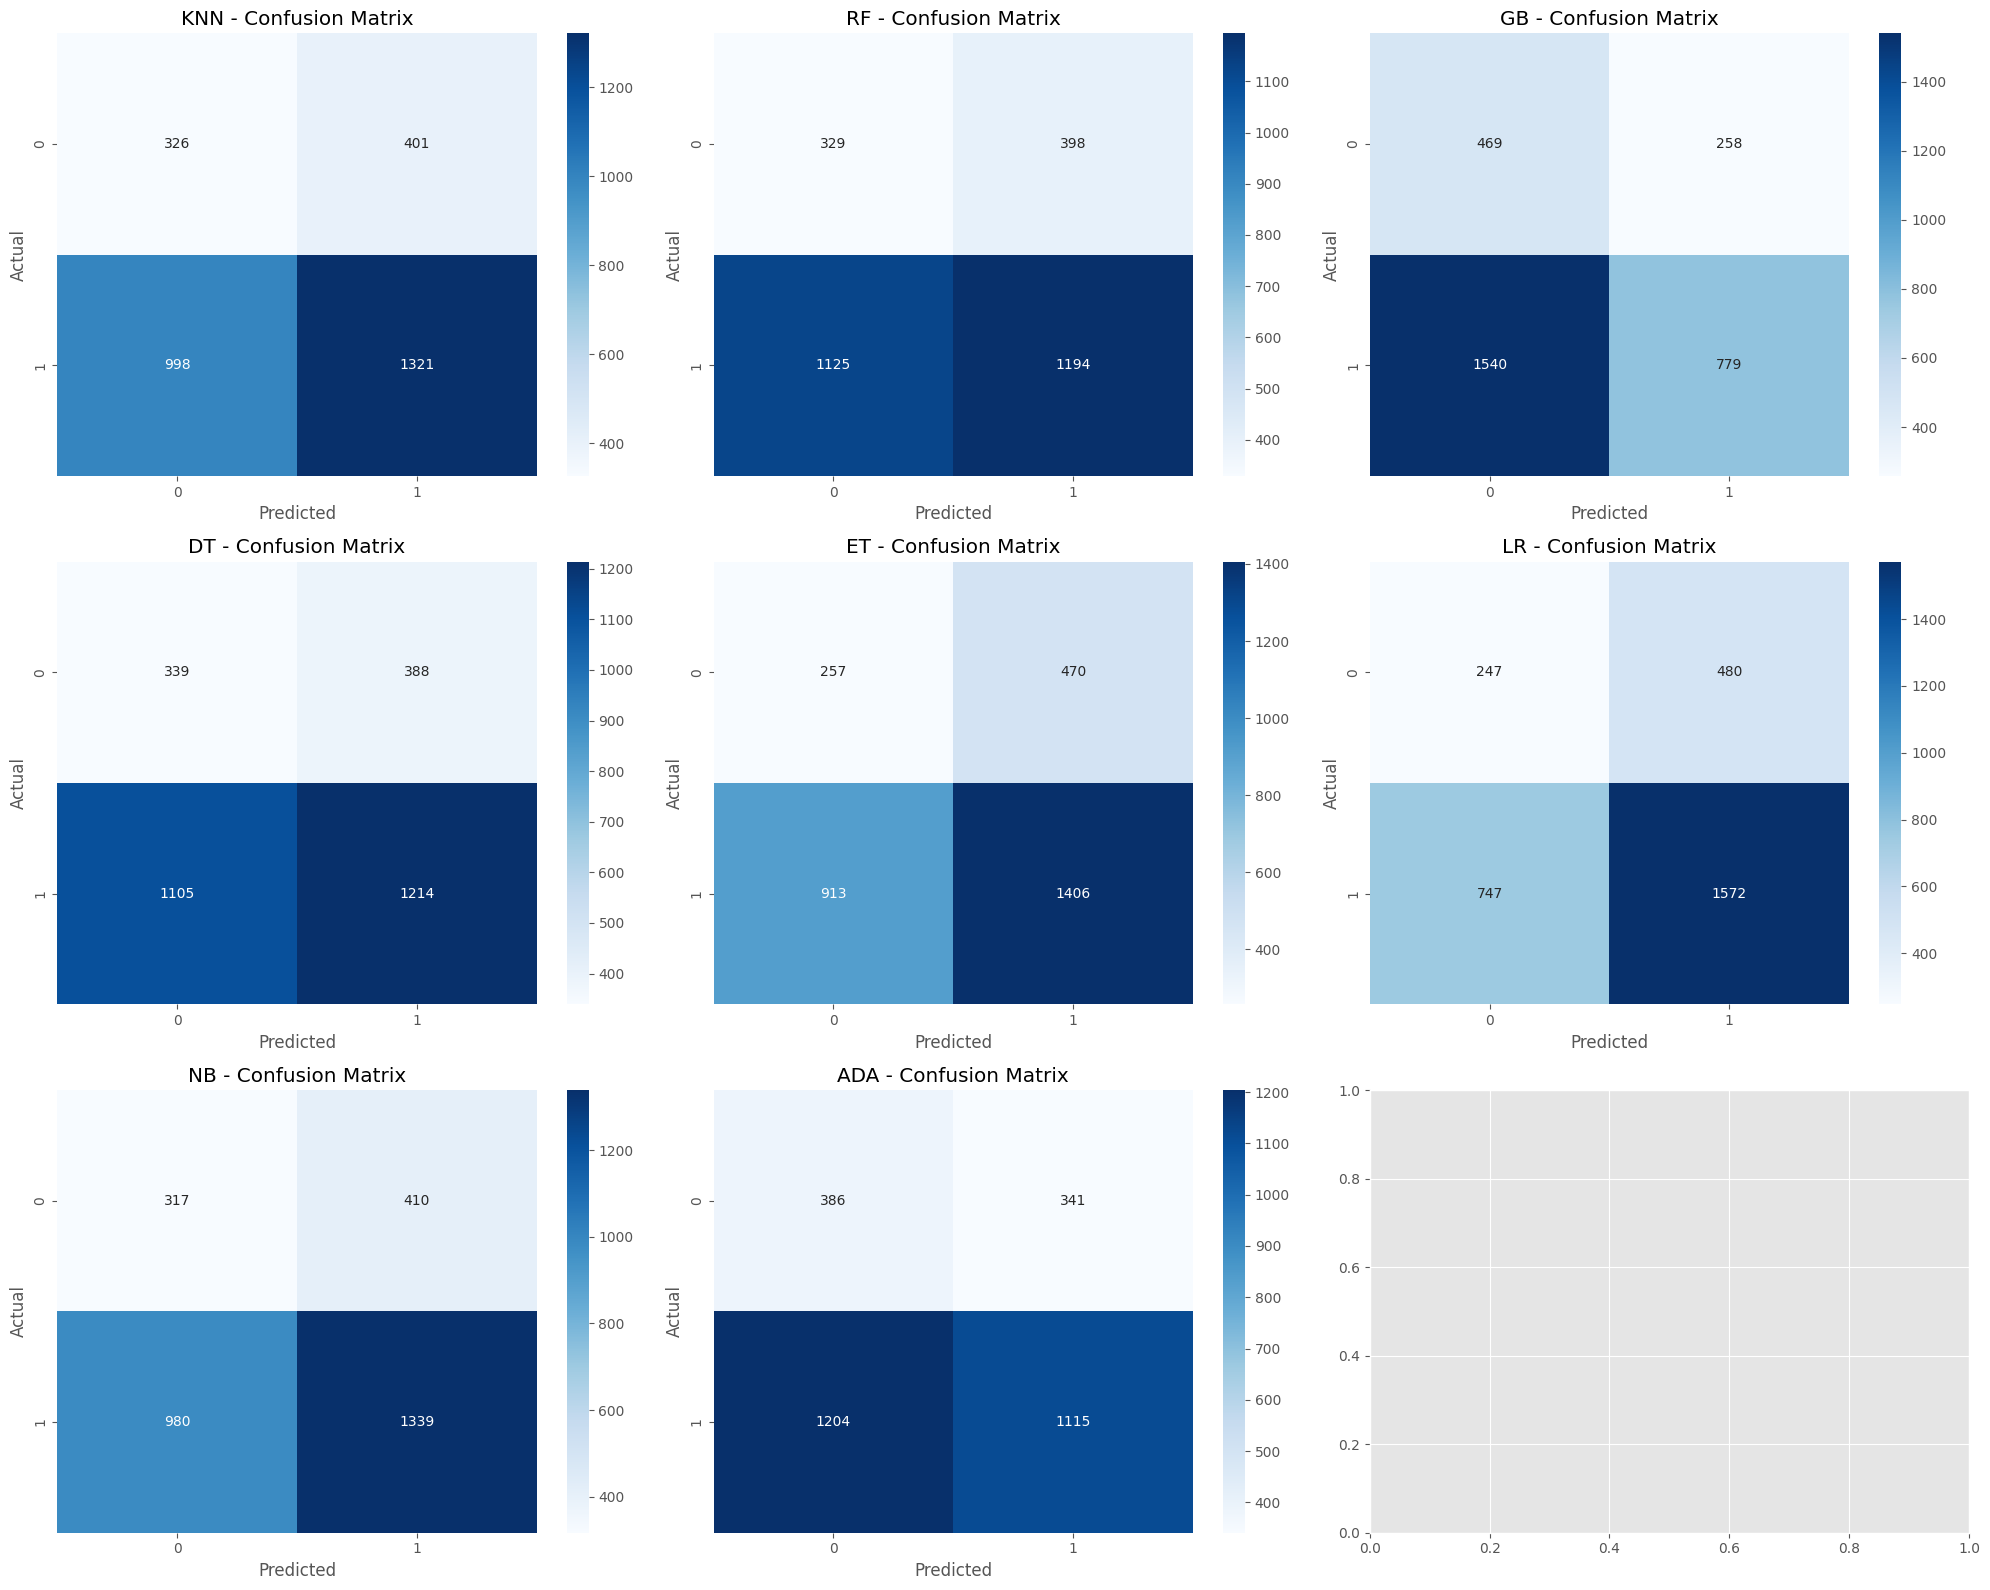

In [215]:
# Plotting confusion matrix for all the models that we trained
fig, axes = plt.subplots(3, 3, figsize=(20, 16))
axes = axes.flatten()

for i, result in enumerate(balanced_results):
    if i >= len(axes):
        break
        
    model_name = result['model_name']
    cm = result['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"{model_name} - Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

## 9. Models performance comparison

In [216]:
# Extracting metrics that we need for comparison
def extract_metrics(results):
    model_names = []
    accuracies = []
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    aucs = []
    
    # Appending all the metrics to the lists that we created above
    for result in results:
        model_names.append(result['model_name'])
        accuracies.append(result['accuracy'])
        balanced_accuracies.append(result['balanced_accuracy'])
        precisions.append(result['precision'])
        recalls.append(result['recall'])
        f1_scores.append(result['f1'])
        aucs.append(result['auc'] if result['auc'] is not None else np.nan)
    
    # Returnning the metrics in a form of dict
    return {
        'model_names': model_names,
        'accuracies': accuracies,
        'balanced_accuracies': balanced_accuracies,
        'precisions': precisions,
        'recalls': recalls,
        'f1_scores': f1_scores,
        'aucs': aucs
    }

In [217]:
# Creating a dataframe to compare the performances
balanced_metrics = extract_metrics(balanced_results)

metrics_df = pd.DataFrame({
    'Model': balanced_metrics['model_names'],
    'Accuracy': balanced_metrics['accuracies'],
    'Balanced Accuracy': balanced_metrics['balanced_accuracies'],
    'Precision': balanced_metrics['precisions'],
    'Recall': balanced_metrics['recalls'],
    'F1 Score': balanced_metrics['f1_scores'],
    'AUC': balanced_metrics['aucs']
})


In [218]:
# Soritng based on F1 score in a descending order
metrics_df = metrics_df.sort_values(by='F1 Score', ascending=False)

In [219]:
# Printing comparison table
print("\n Model Performance Comparison (sorted by F1 Score): \n")
metrics_df


 Model Performance Comparison (sorted by F1 Score): 



,Model,Accuracy,Balanced Accuracy,Precision,Recall,F1 Score,AUC
5,LR,0.597177,0.508815,0.642547,0.597177,0.616121,0.507377
6,NB,0.543664,0.506721,0.641191,0.543664,0.575950,0.502999
4,ET,0.545962,0.479902,0.623016,0.545962,0.575003,0.476984
0,KNN,0.540709,0.509030,0.642804,0.540709,0.573627,0.511302
3,DT,0.509849,0.494901,0.632967,0.509849,0.545973,0.501085
1,RF,0.500000,0.483711,0.625000,0.500000,0.536862,0.488364
7,ADA,0.492777,0.505880,0.640963,0.492777,0.529261,0.505764
2,GB,0.409718,0.490519,0.627631,0.409718,0.435267,0.481694


In [220]:
# For plotting the metrics in bar graph
metrics_to_plot = ['Accuracy', 'Balanced Accuracy', 'Precision', 'Recall', 'F1 Score']
plot_df = metrics_df.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')

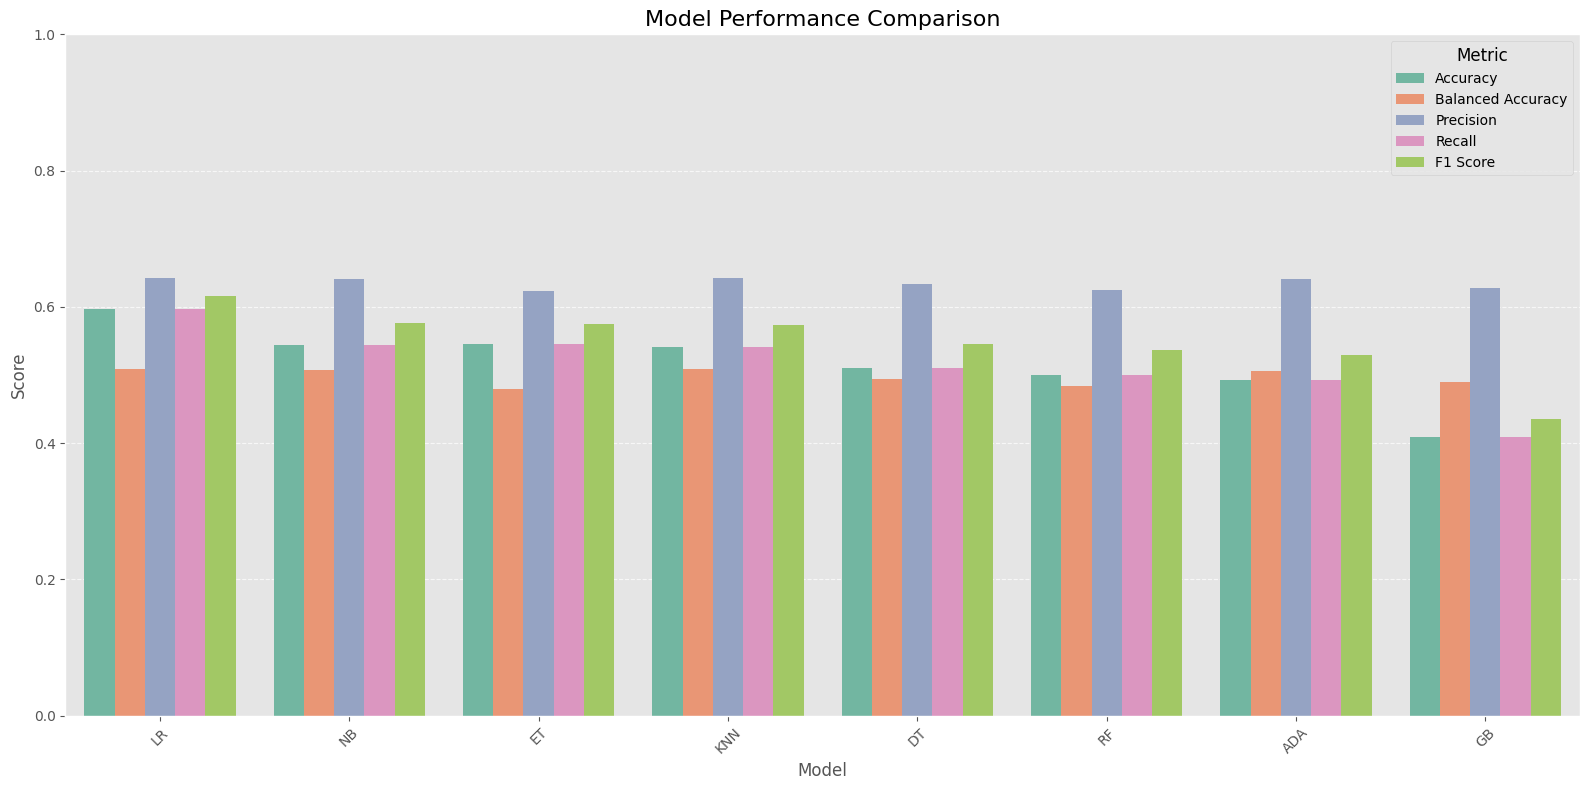

In [221]:
# Plotting the bar graph
plt.figure(figsize=(16, 8))
sns.barplot(x='Model', y='Score', hue='Metric', data=plot_df)
plt.title('Model Performance Comparison', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metric', title_fontsize=12)
plt.tight_layout()
plt.show()

## 10. Selecting the model based on best F1 score

In [222]:
# Finding best model based on F1 score
best_model_idx = metrics_df['F1 Score'].idxmax()
best_model_info = metrics_df.loc[best_model_idx]

In [223]:
# Printing the metrics for the best models that we selected
print(f"\n Best model based on F1 score: {best_model_info['Model']} \n")
print(f"F1 Score: {best_model_info['F1 Score']:.4f}")
print(f"Accuracy: {best_model_info['Accuracy']:.4f}")
print(f"Balanced Accuracy: {best_model_info['Balanced Accuracy']:.4f}")
print(f"Precision: {best_model_info['Precision']:.4f}")
print(f"Recall: {best_model_info['Recall']:.4f}")
if not np.isnan(best_model_info['AUC']):
    print(f"AUC: {best_model_info['AUC']:.4f}")


 Best model based on F1 score: LR 

F1 Score: 0.6161
Accuracy: 0.5972
Balanced Accuracy: 0.5088
Precision: 0.6425
Recall: 0.5972
AUC: 0.5074


## 11. Saving the best model for streamlit deployment

In [224]:
# Saving our best model 
best_model_name = best_model_info['Model']
print(f"Saving {best_model_name} model since it performed best with F1 score of {best_model_info['F1 Score']:.4f}")
best_model = optimized_models[best_model_name]

Saving LR model since it performed best with F1 score of 0.6161


In [225]:
# Creating a pipeline with preprocessing
complete_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

In [226]:
# Fitting the pipeline on the training data
complete_pipeline.fit(X_train, y_train_causality)

# Creating a filename
model_filename = os.path.join(f"{best_model_name}_model.pkl")

c:\Users\potda\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



In [227]:
# Saving the pipeline
with open(model_filename, 'wb') as file:
    pickle.dump(complete_pipeline, file)

print(f"Model saved to {model_filename}")

Model saved to LR_model.pkl


## END